<a href="https://colab.research.google.com/github/sanketsans/Pix-2-Pix-GAN/blob/main/FridgeFood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np 
from torchvision import transforms
from torchvision import datasets
import random 
from PIL import Image
import matplotlib.pyplot as plt
import os

train_on_gpu = True if torch.cuda.is_available() else False
train_on_gpu

False

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
del len

740 500


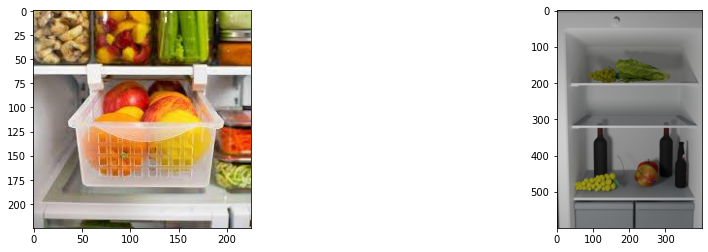

In [4]:
in_domain_imgs = '/content/gdrive/My Drive/in_domain/in_domain/'
synthetic_imgs = '/content/gdrive/My Drive/synthetic/synthetic/'
root_dir = '/content/gdrive/My Drive/'
os.chdir('/content/gdrive/My Drive/')

fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=2)
N_in_domain_imgs = [name for name in os.listdir(in_domain_imgs)]
N_synthetic_imgs = [name for name in os.listdir(synthetic_imgs)]

print(len(N_in_domain_imgs), len(N_synthetic_imgs))
imgs = []
imgs.append(Image.open(in_domain_imgs + N_in_domain_imgs[0]))
imgs.append(Image.open(synthetic_imgs + N_synthetic_imgs[0]))
for ax, img in zip(axes.flatten(), imgs):
  i = ax.imshow(img)

plt.show()


In [6]:
transform = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.RandomRotation(10), 
                                transforms.ToTensor()
                              ])
Imgs_in_domain = datasets.ImageFolder(root_dir + 'in_domain/', transform=transform)
Imgs_synthetic = datasets.ImageFolder(root_dir + 'synthetic/', transform=transform)

In [7]:
DL_in_domain = torch.utils.data.DataLoader(Imgs_in_domain, batch_size=16, num_workers=0, shuffle=True)
DL_synthetic = torch.utils.data.DataLoader(Imgs_synthetic, batch_size=16, num_workers=0, shuffle=True)

In [8]:
a = iter(DL_in_domain)
img, _ = a.next()
img.shape

torch.Size([16, 3, 256, 256])

In [9]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
  layers = []
  conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv)
  if batch_norm:
    batch_norm_layer = nn.BatchNorm2d(out_channels)
    layers.append(batch_norm_layer)

  return nn.Sequential(*layers)

In [11]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
  layers = []
  deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(deconv)
  if batch_norm:
    batchNorm = nn.BatchNorm2d(out_channels)
    layers.append(batchNorm)

  return nn.Sequential(*layers)

In [12]:
def in_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  conv1 = conv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)
  conv2 = conv(out_channel, out_channel, kernel_size, stride, padding, batchNorm)

  layers = [conv1, conv2]

  return nn.Sequential(*layers)

In [13]:
def down_samp_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  pool_layer = nn.MaxPool2d(2, 2)
  conv_layers = in_conv(in_channel, out_channel, batchNorm)

  layers = [pool_layer, conv_layers]
  return nn.Sequential(*layers)

In [14]:
def up_samp_conv(in_channel, out_channel, batchNorm, kernel_size=4, stride=2, padding=1):
  deconv_layer = deconv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)

  return nn.Sequential(deconv_layer)

In [15]:
class Generator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Generator, self).__init__()
    self.seed = 42
    ## input 3x256x256
    self.in_layer = in_conv(3, conv_dims, True) ## 32x128x128 32x256x256

    self.down_samp_conv1 = down_samp_conv(conv_dims, conv_dims*2, True) ## 64x64x64  64x128x128
    self.down_samp_conv2 = down_samp_conv(conv_dims*2, conv_dims*4, True) ## 128x32x32 128x64x64
    self.down_samp_conv3 = down_samp_conv(conv_dims*4, conv_dims*8, True) ## 256x16x16 256x32x32
    self.down_samp_conv4 = down_samp_conv(conv_dims*8, conv_dims*16, True) ## 512x16x16

    self.up_samp_conv0 = up_samp_conv(conv_dims*16, conv_dims*8, True) ## 256x32x32
    self.up_concat_conv0 = in_conv(conv_dims*16, conv_dims*8, True) 
    self.up_samp_conv1 = up_samp_conv(conv_dims*8, conv_dims*4, True)  ## 128x64x64
    self.up_concat_conv1 = in_conv(conv_dims*8, conv_dims*4, True)
    self.up_samp_conv2 = up_samp_conv(conv_dims*4, conv_dims*2, True) ## 64x128x128
    self.up_concat_conv2 = in_conv(conv_dims*4, conv_dims*2, True)
    self.up_samp_conv3 = up_samp_conv(conv_dims*2, conv_dims, True) ## 32x256x256
    self.up_concat_conv3 = in_conv(conv_dims*2, conv_dims, True)

    self.out_layer = nn.Sequential(*[conv(conv_dims, 4, batchNorm=True),
                                     conv(4, 4)])
    
    # in_conv(conv_dims, 4)

  def forward(self, x):
    ## Input size 3x256x256
    l1 = F.relu(self.in_layer(x)) ## 32x256x256
    d_l2 = F.relu(self.down_samp_conv1(l1)) ## 64x128x128
    d_l3 = F.relu(self.down_samp_conv2(d_l2)) ## 128x64x64
    d_l4 = F.relu(self.down_samp_conv3(d_l3)) ## 256x32x32
    d_l5 = F.relu(self.down_samp_conv4(d_l4)) ## 512x16x16

    up_l0 = F.relu(self.up_samp_conv0(d_l5)) ## 256x32x32
    up_l0_concat = torch.cat([up_l0, d_l4], dim=1) ## 512x32x32
    up_l0_concat = F.relu(self.up_concat_conv0(up_l0_concat)) ## 256x32x32

    up_l1 = F.relu(self.up_samp_conv1(d_l4)) ## 128x64x64
    up_l1_concat = torch.cat([up_l1, d_l3], dim=1) ## 256x32x32
    up_l1 = F.relu(self.up_concat_conv1(up_l1_concat))  ## 128x64x64

    up_l2 = F.relu(self.up_samp_conv2(up_l1)) ## 64x128x128
    up_l2_concat = torch.cat([up_l2, d_l2], dim=1) ## 128x128x128
    up_l2 = F.relu(self.up_concat_conv2(up_l2_concat))  ## 64x128x128

    up_l3 = F.relu(self.up_samp_conv3(up_l2)) ## 32x256x256
    up_l3_concat = torch.cat([up_l3, l1], dim=1) ## 64x256x256
    up_l3 = F.relu(self.up_concat_conv3(up_l3_concat))  ## 32x256x256

    out_layer = torch.tanh(self.out_layer(up_l3)) ## 4x256x236

    return out_layer
